In [2]:
# scikit-learn(머신러닝)과 seaborn(시각화) 설치
%pip install scikit-learn seaborn

  Using cached scikit_learn-1.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scipy-1.13.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scipy-1.13.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


/home/lsw0927/miniconda3/envs/transgem/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📂 Loading generated files...


Reading Files: 100%|██████████| 9/9 [00:00<00:00, 222.39it/s]


✅ Total Molecules Loaded: 90000
Disease  Temperature
A549     0.8            10000
         1.0            10000
         1.2            10000
MCF7     0.8            10000
         1.0            10000
         1.2            10000
PC3      0.8            10000
         1.0            10000
         1.2            10000
dtype: int64

🧪 Calculating Fingerprints (This uses CPU)...


RDKit Processing:   0%|          | 0/90000 [00:00<?, ?it/s][12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerator
[12:43:49] DEPRECATION WARNING: please use MorganGenerat

✅ Fingerprint Calculation Complete.
   - Valid Molecules: 90000 (100.0%)
   - Invalid Molecules: 0

📉 Sampling 30000 molecules for t-SNE visualization (to save time)...
🗺️ Running t-SNE... (This takes about 10-20 mins)

🎨 Plotting...


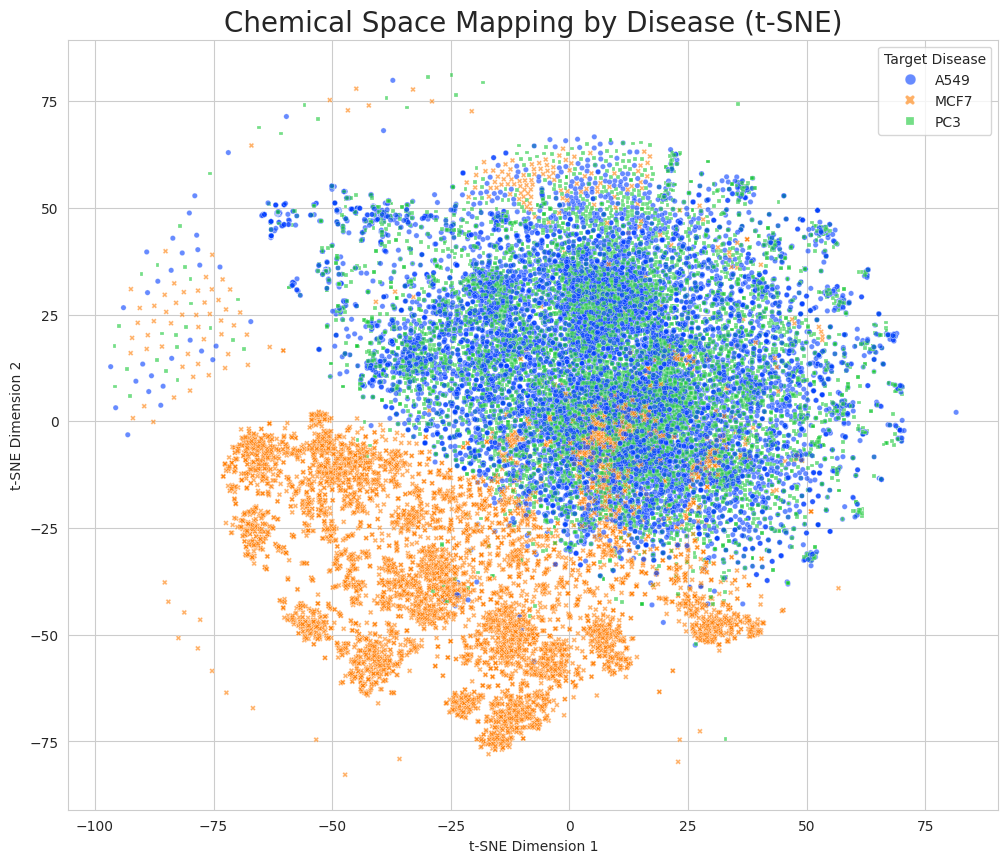

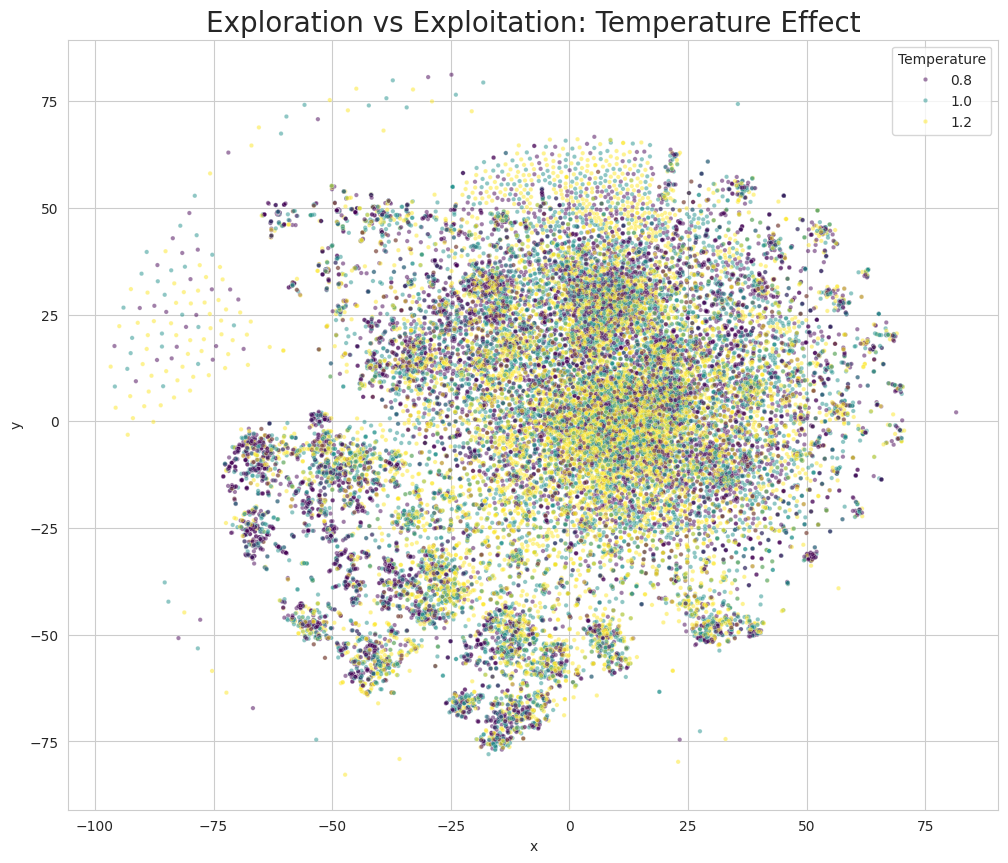

🎉 Analysis Complete! Check the saved PNG files.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
import glob
import os

# 그래프 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# --- 1. 데이터 로드 (모든 생성 파일 읽어오기) ---
result_dir = "experiment3_results"
all_molecules = []

print("📂 Loading generated files...")
file_list = glob.glob(f"{result_dir}/gen_*.txt")

for filepath in tqdm(file_list, desc="Reading Files"):
    # 파일명에서 조건 파싱 (예: gen_PC3_temp1.0.txt)
    filename = os.path.basename(filepath)
    parts = filename.replace("gen_", "").replace(".txt", "").split("_temp")
    disease = parts[0]
    temp = float(parts[1])
    
    with open(filepath, "r") as f:
        lines = f.readlines()
        for line in lines:
            smi = line.strip()
            if smi: # 빈 줄 제외
                all_molecules.append({
                    "SMILES": smi,
                    "Disease": disease,
                    "Temperature": temp
                })

df = pd.DataFrame(all_molecules)
print(f"✅ Total Molecules Loaded: {len(df)}")
print(df.groupby(['Disease', 'Temperature']).size())

# --- 2. Fingerprint 계산 (화학적 특징 추출) ---
# SMILES(문자열) -> Morgan Fingerprint(2048비트 벡터)
print("\n🧪 Calculating Fingerprints (This uses CPU)...")

fps = []
valid_indices = []
invalid_count = 0

# RDKit 변환 루프
for idx, smi in tqdm(enumerate(df['SMILES']), total=len(df), desc="RDKit Processing"):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            # Radius 2, 1024-bit Morgan Fingerprint
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            
            # RDKit 벡터를 Numpy 배열로 변환
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(idx)
        else:
            invalid_count += 1
    except:
        invalid_count += 1

# 유효한 데이터만 남기기
df_valid = df.iloc[valid_indices].copy()
X = np.array(fps)

print(f"✅ Fingerprint Calculation Complete.")
print(f"   - Valid Molecules: {len(df_valid)} ({len(df_valid)/len(df)*100:.1f}%)")
print(f"   - Invalid Molecules: {invalid_count}")

# --- 3. t-SNE 수행 (차원 축소) ---
# 데이터가 너무 많으면 t-SNE가 너무 오래 걸리므로, 시각화용으로 최대 3만 개만 샘플링합니다.
# (통계는 전체로 하되, 그림은 샘플링해도 충분함)
SAMPLE_SIZE = 30000

if len(df_valid) > SAMPLE_SIZE:
    print(f"\n📉 Sampling {SAMPLE_SIZE} molecules for t-SNE visualization (to save time)...")
    indices = np.random.choice(len(df_valid), SAMPLE_SIZE, replace=False)
    X_sample = X[indices]
    df_sample = df_valid.iloc[indices].copy()
else:
    X_sample = X
    df_sample = df_valid.copy()

print("🗺️ Running t-SNE... (This takes about 10-20 mins)")
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_sample)

df_sample['x'] = X_tsne[:, 0]
df_sample['y'] = X_tsne[:, 1]

# --- 4. 시각화 (Chemical Space Map) ---
print("\n🎨 Plotting...")

# Plot 1: 질병별 분포 (Disease Specificity)
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_sample, x='x', y='y', 
    hue='Disease', style='Disease',
    palette='bright', alpha=0.6, s=15
)
plt.title("Chemical Space Mapping by Disease (t-SNE)", fontsize=20)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Target Disease", markerscale=2)
plt.savefig("Exp3_Chemical_Space_Disease.png", dpi=300)
plt.show()

# Plot 2: 온도별 분포 (Temperature Effect)
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_sample, x='x', y='y', 
    hue='Temperature', palette='viridis', 
    alpha=0.5, s=10
)
plt.title("Exploration vs Exploitation: Temperature Effect", fontsize=20)
plt.legend(title="Temperature")
plt.savefig("Exp3_Chemical_Space_Temp.png", dpi=300)
plt.show()

print("🎉 Analysis Complete! Check the saved PNG files.")